In [37]:
# Setting the environment variables

In [141]:
import os
import sys
os.environ["PYSPARK_PYTHON"]="/usr/bin/python3"
os.environ["PYSPARK_DRIVER_PYTHON"]="/usr/bin/python3"
os.environ["PYSPARK_DRIVER_PYTHON_OPTS"]="notebook --no-browser"
os.environ["JAVA_HOME"] = "/usr/java/jdk1.8.0_161/jre"
os.environ["SPARK_HOME"] = "/home/ec2-user/spark-2.4.4-bin-hadoop2.7"
os.environ["PYLIB"] = os.environ["SPARK_HOME"] + "/python/lib"
sys.path.insert(0, os.environ["PYLIB"] + "/py4j-0.10.7-src.zip")
sys.path.insert(0, os.environ["PYLIB"] + "/pyspark.zip")

# Ecommerce Churn Assignment

The aim of the assignment is to build a model that predicts whether a person purchases an item after it has been added to the cart or not. Being a classification problem, you are expected to use your understanding of all the three models covered till now. You must select the most robust model and provide a solution that predicts the churn in the most suitable manner. 

For this assignment, you are provided the data associated with an e-commerce company for the month of October 2019. Your task is to first analyse the data, and then perform multiple steps towards the model building process.

The broad tasks are:
- Data Exploration
- Feature Engineering
- Model Selection
- Model Inference

### Data description

The dataset stores the information of a customer session on the e-commerce platform. It records the activity and the associated parameters with it.

- **event_time**: Date and time when user accesses the platform
- **event_type**: Action performed by the customer
            - View
            - Cart
            - Purchase
            - Remove from cart
- **product_id**: Unique number to identify the product in the event
- **category_id**: Unique number to identify the category of the product
- **category_code**: Stores primary and secondary categories of the product
- **brand**: Brand associated with the product
- **price**: Price of the product
- **user_id**: Unique ID for a customer
- **user_session**: Session ID for a user


### Initialising the SparkSession

The dataset provided is 5 GBs in size. Therefore, it is expected that you increase the driver memory to a greater number. You can refer to notebook 1 for the steps involved here.

In [142]:
# Spark environment
from pyspark import SparkConf
from pyspark.sql import SparkSession

In [143]:
MAX_MEMORY = "14G"

spark = SparkSession \
    .builder \
    .appName("demo") \
    .config("spark.driver.memory", MAX_MEMORY) \
    .getOrCreate()

spark

In [144]:
import numpy as np
import matplotlib.pyplot as plt
import squarify
import matplotlib.dates as dates
from datetime import datetime

%matplotlib inline

In [145]:
import pandas as pd

In [146]:
import warnings
warnings.filterwarnings('ignore')

In [147]:
# Loading the clean data

cleaned_df = pd.read_csv("cleaned_df.csv")

In [148]:
cleaned_df.head()

,Unnamed: 0,event_type,product_id,price,user_id,user_session,event_date,category_code_level1,category_code_level2,activity_count,hour,weekday,is_purchased
0,0,purchase,1004856,130.76,543272936,8187d148-3c41-46d4-b0c0-9c08cd9dc564,2019-10-01,electronics,smartphone,4,12,Tuesday,1
1,1,purchase,1002532,642.69,551377651,3c80f0d6-e9ec-4181-8c5c-837a30be2d68,2019-10-01,electronics,smartphone,11,12,Tuesday,1
2,2,purchase,13800054,54.42,555332717,1dea3ee2-2ded-42e8-8e7a-4e2ad6ae942f,2019-10-01,furniture,bathroom,2,12,Tuesday,1
3,3,purchase,4804055,189.91,524601178,2af9b570-0942-4dcd-8f25-4d84fba82553,2019-10-01,electronics,audio,3,12,Tuesday,1
4,4,cart,1002524,515.67,524325294,0b74a829-f9d7-4654-b5b0-35bc9822c238,2019-10-01,electronics,smartphone,4,12,Tuesday,0


In [149]:
cleaned_df.reset_index(drop=True, inplace=True)

In [150]:
cleaned_df.head()

,Unnamed: 0,event_type,product_id,price,user_id,user_session,event_date,category_code_level1,category_code_level2,activity_count,hour,weekday,is_purchased
0,0,purchase,1004856,130.76,543272936,8187d148-3c41-46d4-b0c0-9c08cd9dc564,2019-10-01,electronics,smartphone,4,12,Tuesday,1
1,1,purchase,1002532,642.69,551377651,3c80f0d6-e9ec-4181-8c5c-837a30be2d68,2019-10-01,electronics,smartphone,11,12,Tuesday,1
2,2,purchase,13800054,54.42,555332717,1dea3ee2-2ded-42e8-8e7a-4e2ad6ae942f,2019-10-01,furniture,bathroom,2,12,Tuesday,1
3,3,purchase,4804055,189.91,524601178,2af9b570-0942-4dcd-8f25-4d84fba82553,2019-10-01,electronics,audio,3,12,Tuesday,1
4,4,cart,1002524,515.67,524325294,0b74a829-f9d7-4654-b5b0-35bc9822c238,2019-10-01,electronics,smartphone,4,12,Tuesday,0


<hr>

## Task 3: Model Selection
3 models for classification:	
- Logistic Regression
- Decision Tree
- Random Forest

### Model 1: Logistic Regression

In [151]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 363602 entries, 0 to 363601
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Unnamed: 0            363602 non-null  int64  
 1   event_type            363602 non-null  object 
 2   product_id            363602 non-null  int64  
 3   price                 363602 non-null  float64
 4   user_id               363602 non-null  int64  
 5   user_session          363602 non-null  object 
 6   event_date            363602 non-null  object 
 7   category_code_level1  363602 non-null  object 
 8   category_code_level2  363602 non-null  object 
 9   activity_count        363602 non-null  int64  
 10  hour                  363602 non-null  int64  
 11  weekday               363602 non-null  object 
 12  is_purchased          363602 non-null  int64  
dtypes: float64(1), int64(6), object(6)
memory usage: 36.1+ MB


In [152]:
cleaned_df.shape

(363602, 13)

In [153]:
## Checking for Outliers

In [154]:
outliers = cleaned_df[['price','activity_count','hour']]

In [155]:
# Checking outliers at 25%, 50%, 75%, 90%, 95% and 99%
outliers.describe(percentiles=[.25, .5, .75, .90, .95, .99])

,price,activity_count,hour
count,363602.000000,363602.000000,363602.000000
mean,358.756093,8.053633,6.269792
std,364.276623,8.606192,3.217436
min,0.880000,1.000000,1.000000
25%,131.530000,3.000000,4.000000
50%,229.390000,5.000000,6.000000
75%,458.870000,9.000000,9.000000
90%,952.150000,16.000000,11.000000
95%,1093.850000,22.000000,12.000000
99%,1725.030000,43.000000,12.000000


#### Feature Transformation

In [156]:
# Check if only the required columns are present to build the model
# If not, drop the redundant columns

cleaned_df = cleaned_df.drop(cleaned_df.columns[[0,6]], axis=1)

In [157]:
cleaned_df.head()


,event_type,product_id,price,user_id,user_session,category_code_level1,category_code_level2,activity_count,hour,weekday,is_purchased
0,purchase,1004856,130.76,543272936,8187d148-3c41-46d4-b0c0-9c08cd9dc564,electronics,smartphone,4,12,Tuesday,1
1,purchase,1002532,642.69,551377651,3c80f0d6-e9ec-4181-8c5c-837a30be2d68,electronics,smartphone,11,12,Tuesday,1
2,purchase,13800054,54.42,555332717,1dea3ee2-2ded-42e8-8e7a-4e2ad6ae942f,furniture,bathroom,2,12,Tuesday,1
3,purchase,4804055,189.91,524601178,2af9b570-0942-4dcd-8f25-4d84fba82553,electronics,audio,3,12,Tuesday,1
4,cart,1002524,515.67,524325294,0b74a829-f9d7-4654-b5b0-35bc9822c238,electronics,smartphone,4,12,Tuesday,0


In [158]:
cleaned_df.isnull().sum()

event_type              0
product_id              0
price                   0
user_id                 0
user_session            0
category_code_level1    0
category_code_level2    0
activity_count          0
hour                    0
weekday                 0
is_purchased            0
dtype: int64

In [159]:
# Feature transformation for categorical features

dummy1 = pd.get_dummies(cleaned_df['event_type'], drop_first=True)

# Adding the results to the master dataframe
cleaned_df = pd.concat([cleaned_df, dummy1], axis=1)

In [160]:
# Schema of the transformed df

cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 363602 entries, 0 to 363601
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   event_type            363602 non-null  object 
 1   product_id            363602 non-null  int64  
 2   price                 363602 non-null  float64
 3   user_id               363602 non-null  int64  
 4   user_session          363602 non-null  object 
 5   category_code_level1  363602 non-null  object 
 6   category_code_level2  363602 non-null  object 
 7   activity_count        363602 non-null  int64  
 8   hour                  363602 non-null  int64  
 9   weekday               363602 non-null  object 
 10  is_purchased          363602 non-null  int64  
 11  purchase              363602 non-null  uint8  
dtypes: float64(1), int64(5), object(5), uint8(1)
memory usage: 30.9+ MB


In [161]:
# Checking the elements of the transformed df - Top 20 rows

cleaned_df.head(20)

,event_type,product_id,price,user_id,user_session,category_code_level1,category_code_level2,activity_count,hour,weekday,is_purchased,purchase
0,purchase,1004856,130.76,543272936,8187d148-3c41-46d4-b0c0-9c08cd9dc564,electronics,smartphone,4,12,Tuesday,1,1
1,purchase,1002532,642.69,551377651,3c80f0d6-e9ec-4181-8c5c-837a30be2d68,electronics,smartphone,11,12,Tuesday,1,1
2,purchase,13800054,54.42,555332717,1dea3ee2-2ded-42e8-8e7a-4e2ad6ae942f,furniture,bathroom,2,12,Tuesday,1,1
3,purchase,4804055,189.91,524601178,2af9b570-0942-4dcd-8f25-4d84fba82553,electronics,audio,3,12,Tuesday,1,1
4,cart,1002524,515.67,524325294,0b74a829-f9d7-4654-b5b0-35bc9822c238,electronics,smartphone,4,12,Tuesday,0,0
5,purchase,6200687,28.03,548691404,b67cdbcb-b073-4271-b365-803c6fce53b0,appliances,environment,8,12,Tuesday,1,1
6,cart,4804056,161.98,533624186,e5ac3caa-e6d5-4d6b-ae06-2c18cd9ca683,electronics,audio,4,12,Tuesday,0,0
7,purchase,1004932,463.31,555083442,83d12d1a-5452-4fa0-abbb-d9f492f8b562,electronics,smartphone,3,12,Tuesday,1,1
8,cart,1004833,174.76,536415846,685b5b42-f597-4a69-ab4c-ef96a30bc454,electronics,smartphone,7,2,Tuesday,0,0
9,purchase,1004246,736.18,515246296,b7dbae4f-cad3-463e-89ce-41990cf48dea,electronics,smartphone,3,2,Tuesday,1,1


In [162]:
#pip install seaborn

In [163]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

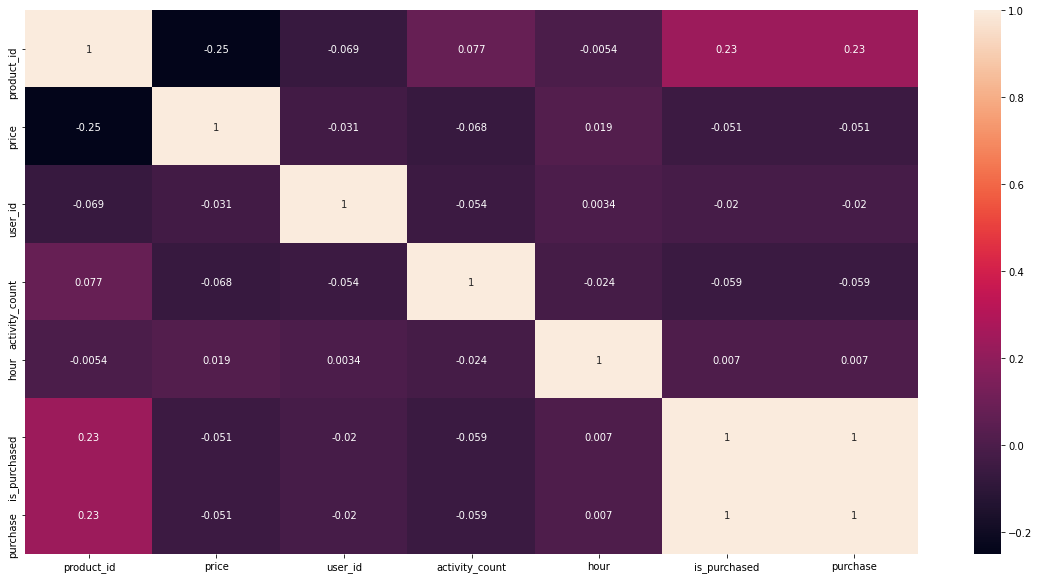

In [164]:
# Let's see the correlation matrix 
plt.figure(figsize = (20,10))        # Size of the figure
sns.heatmap(cleaned_df.corr(),annot = True)
plt.show()

#### Train-test split

In [165]:
#pip install sklearn

In [166]:
from sklearn.model_selection import train_test_split

In [167]:
# Splitting the data into train and test (Remember you are expected to compare the model later)

# Putting feature variable to X
X = cleaned_df.drop(['is_purchased','weekday','purchase','user_id','user_session','category_code_level1','category_code_level2','event_type','product_id'], axis=1)

# Putting predict variable to y
y = cleaned_df['is_purchased']



In [168]:
# Number of rows in train and test data

X.head()


,price,activity_count,hour
0,130.76,4,12
1,642.69,11,12
2,54.42,2,12
3,189.91,3,12
4,515.67,4,12


In [169]:
y.head()

0    1
1    1
2    1
3    1
4    0
Name: is_purchased, dtype: int64

In [170]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=100)

#### Model Fitting

In [171]:
#pip install statsmodels

In [172]:
# Building the model

import statsmodels.api as sm

In [173]:
# Logistic regression model
logm1 = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
logm1.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           is_purchased   No. Observations:               254521
Model:                            GLM   Df Residuals:                   254517
Model Family:                Binomial   Df Model:                            3
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.5128e+05
Date:                Wed, 03 Feb 2021   Deviance:                   3.0255e+05
Time:                        16:23:09   Pearson chi2:                 2.57e+05
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.6602      0.012    -56.294      0.000      -0.683      -0.637
price             -0.0004   1.29e-05    -29.300      0.000      -0.000      -0.000
activity_count    -0.0199      0.001    -31.634      0.000      -0.021      -0.019
hour               0.0047      0.001      3.416      0.001       0.002       0.007
==================================================================================
"""

In [174]:
# Calculating ecommerce churn

e_churn = (sum(cleaned_df['is_purchased'])/len(cleaned_df['is_purchased'].index))*100
e_churn


28.490767377517173

In [175]:
# Feature Selection Using RFE

In [176]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()

In [177]:
from sklearn.feature_selection import RFE
rfe = RFE(logreg, 15)             
rfe = rfe.fit(X_train, y_train)

In [178]:
rfe.support_

array([ True,  True,  True])

In [179]:
list(zip(X_train.columns, rfe.support_, rfe.ranking_))

[('price', True, 1), ('activity_count', True, 1), ('hour', True, 1)]

In [180]:
col = X_train.columns[rfe.support_]

In [181]:
X_train.columns[~rfe.support_]

Index([], dtype='object')

In [182]:
#Assessing the model with StatsModels

In [183]:
X_train_sm = sm.add_constant(X_train[col])
logm2 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm2.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           is_purchased   No. Observations:               254521
Model:                            GLM   Df Residuals:                   254517
Model Family:                Binomial   Df Model:                            3
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.5128e+05
Date:                Wed, 03 Feb 2021   Deviance:                   3.0255e+05
Time:                        16:23:22   Pearson chi2:                 2.57e+05
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.6602      0.012    -56.294      0.000      -0.683      -0.637
price             -0.0004   1.29e-05    -29.300      0.000      -0.000      -0.000
activity_count    -0.0199      0.001    -31.634      0.000      -0.021      -0.019
hour               0.0047      0.001      3.416      0.001       0.002       0.007
==================================================================================
"""

In [184]:
y_train_pred = res.predict(X_train_sm)
y_train_pred[:10]

194149    0.315941
117498    0.274553
152345    0.328199
131454    0.250422
241904    0.211443
89508     0.299938
238160    0.309106
20583     0.290872
116096    0.335871
151502    0.321419
dtype: float64

In [185]:
y_train_pred = y_train_pred.values.reshape(-1)
y_train_pred[:10]

array([0.31594069, 0.27455269, 0.32819891, 0.25042166, 0.21144274,
       0.29993779, 0.30910555, 0.29087212, 0.33587054, 0.32141889])

In [186]:
y_train_pred_final = pd.DataFrame({'Churn':y_train.values, 'Churn_Prob':y_train_pred})
y_train_pred_final['product_id'] = y_train.index
y_train_pred_final.head()

,Churn,Churn_Prob,product_id
0,0,0.315941,194149
1,0,0.274553,117498
2,1,0.328199,152345
3,1,0.250422,131454
4,0,0.211443,241904


In [187]:
y_train_pred_final['predicted'] = y_train_pred_final.Churn_Prob.map(lambda x: 1 if x > 0.3 else 0)

# Let's see the head
y_train_pred_final.head()

,Churn,Churn_Prob,product_id,predicted
0,0,0.315941,194149,1
1,0,0.274553,117498,0
2,1,0.328199,152345,1
3,1,0.250422,131454,0
4,0,0.211443,241904,0


In [188]:
from sklearn import metrics

In [189]:
# Confusion matrix 
confusion = metrics.confusion_matrix(y_train_pred_final.Churn, y_train_pred_final.predicted )
print(confusion)

[[104483  77348]
 [ 33990  38700]]


In [190]:
# Let's check the overall accuracy.
print(metrics.accuracy_score(y_train_pred_final.Churn, y_train_pred_final.predicted))

0.562558688674019


In [191]:
#Checking VIFs

In [192]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [193]:
#Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train[col].columns
vif['VIF'] = [variance_inflation_factor(X_train[col].values, i) for i in range(X_train[col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
2,hour,2.11
0,price,1.68
1,activity_count,1.58


In [194]:
col = col.drop('hour', 1)
col

Index(['price', 'activity_count'], dtype='object')

In [195]:
# Let's re-run the model using the selected variables
X_train_sm = sm.add_constant(X_train[col])
logm3 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm3.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           is_purchased   No. Observations:               254521
Model:                            GLM   Df Residuals:                   254518
Model Family:                Binomial   Df Model:                            2
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.5128e+05
Date:                Wed, 03 Feb 2021   Deviance:                   3.0257e+05
Time:                        16:23:51   Pearson chi2:                 2.57e+05
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.6308      0.008    -79.325      0.000      -0.646      -0.615
price             -0.0004   1.29e-05    -29.244      0.000      -0.000      -0.000
activity_count    -0.0200      0.001    -31.713      0.000      -0.021      -0.019
==================================================================================
"""

In [196]:
y_train_pred = res.predict(X_train_sm).values.reshape(-1)

In [197]:
y_train_pred[:10]

array([0.31323974, 0.27285361, 0.32237827, 0.25428573, 0.21377067,
       0.29637608, 0.31342098, 0.28645932, 0.33616893, 0.31666297])

In [198]:
y_train_pred_final['Churn_Prob'] = y_train_pred

In [199]:
# Creating new column 'predicted' with 1 if Churn_Prob > 0.5 else 0
y_train_pred_final['predicted'] = y_train_pred_final.Churn_Prob.map(lambda x: 1 if x > 0.5
                                                                    else 0)
y_train_pred_final.head()

,Churn,Churn_Prob,product_id,predicted
0,0,0.313240,194149,0
1,0,0.272854,117498,0
2,1,0.322378,152345,0
3,1,0.254286,131454,0
4,0,0.213771,241904,0


In [200]:
# Let's check the overall accuracy.
print(metrics.accuracy_score(y_train_pred_final.Churn, y_train_pred_final.predicted))

0.7144047053091886


#### Model Analysis

In [201]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [202]:
# Let's see the sensitivity of our logistic regression model
TP / float(TP+FN)

0.5323978539001238

In [203]:
# Let us calculate specificity
TN / float(TN+FP)

0.5746159895727351

In [204]:
# Calculate false postive rate
print(FP/ float(TN+FP))

0.42538401042726487


In [205]:
# positive predictive value 
print (TP / float(TP+FP))

0.333482696815111


In [206]:
# Negative predictive value
print (TN / float(TN+ FN))

0.7545369855495295


In [207]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False)
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

In [208]:
fpr, tpr, thresholds = metrics.roc_curve( y_train, y_train_pred, drop_intermediate = False )

In [209]:
y_train_pred_final.Churn_Prob

0         0.313240
1         0.272854
2         0.322378
3         0.254286
4         0.213771
            ...   
254516    0.166160
254517    0.314403
254518    0.316860
254519    0.271763
254520    0.261700
Name: Churn_Prob, Length: 254521, dtype: float64

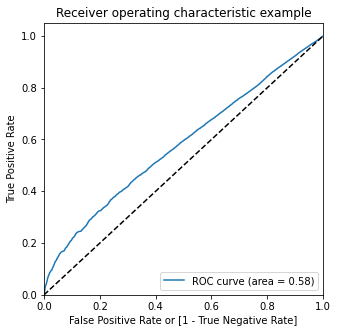

In [210]:
draw_roc(y_train_pred_final.Churn, y_train_pred_final.Churn_Prob)

In [211]:
# Let's create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_train_pred_final[i]= y_train_pred_final.Churn_Prob.map(lambda x: 1 if x > i else 0)
y_train_pred_final.head()

,Churn,Churn_Prob,product_id,predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0,0.313240,194149,0,1,1,1,1,0,0,0,0,0,0
1,0,0.272854,117498,0,1,1,1,0,0,0,0,0,0,0
2,1,0.322378,152345,0,1,1,1,1,0,0,0,0,0,0
3,1,0.254286,131454,0,1,1,1,0,0,0,0,0,0,0
4,0,0.213771,241904,0,1,1,1,0,0,0,0,0,0,0


In [212]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
from sklearn.metrics import confusion_matrix

# TP = confusion[1,1] # true positive 
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix(y_train_pred_final.Churn, y_train_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

     prob  accuracy     sensi     speci
0.0   0.0  0.285595  1.000000  0.000000
0.1   0.1  0.286369  0.997978  0.001892
0.2   0.2  0.302726  0.972871  0.034824
0.3   0.3  0.560005  0.535053  0.569980
0.4   0.4  0.714405  0.000000  1.000000
0.5   0.5  0.714405  0.000000  1.000000
0.6   0.6  0.714405  0.000000  1.000000
0.7   0.7  0.714405  0.000000  1.000000
0.8   0.8  0.714405  0.000000  1.000000
0.9   0.9  0.714405  0.000000  1.000000


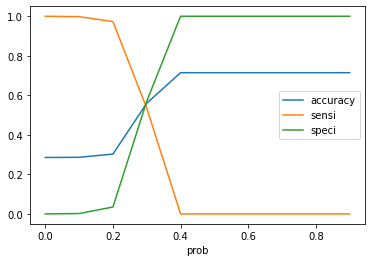

In [215]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()

In [216]:
y_train_pred_final['final_predicted'] = y_train_pred_final.Churn_Prob.map( lambda x: 1 if x > 0.5 else 0)

y_train_pred_final.head()

,Churn,Churn_Prob,product_id,predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,final_predicted
0,0,0.313240,194149,0,1,1,1,1,0,0,0,0,0,0,0
1,0,0.272854,117498,0,1,1,1,0,0,0,0,0,0,0,0
2,1,0.322378,152345,0,1,1,1,1,0,0,0,0,0,0,0
3,1,0.254286,131454,0,1,1,1,0,0,0,0,0,0,0,0
4,0,0.213771,241904,0,1,1,1,0,0,0,0,0,0,0,0


In [217]:
# Let's check the overall accuracy.
metrics.accuracy_score(y_train_pred_final.Churn, y_train_pred_final.final_predicted)

0.7144047053091886

#### From the curve above, 0.3 is the optimum point to take it as a cutoff probability.

In [218]:
y_train_pred_final['final_predicted'] = y_train_pred_final.Churn_Prob.map( lambda x: 1 if x > 0.3 else 0)

y_train_pred_final.head()

,Churn,Churn_Prob,product_id,predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,final_predicted
0,0,0.313240,194149,0,1,1,1,1,0,0,0,0,0,0,1
1,0,0.272854,117498,0,1,1,1,0,0,0,0,0,0,0,0
2,1,0.322378,152345,0,1,1,1,1,0,0,0,0,0,0,1
3,1,0.254286,131454,0,1,1,1,0,0,0,0,0,0,0,0
4,0,0.213771,241904,0,1,1,1,0,0,0,0,0,0,0,0


In [219]:
# Let's check the overall accuracy.
metrics.accuracy_score(y_train_pred_final.Churn, y_train_pred_final.final_predicted)

0.5600048718966215